# Classification Problem : Credit Card Offer

### Importing the librairies

In [237]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy import stats

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import pickle

import warnings
warnings.filterwarnings('ignore')

## 1. Cleaning the CSV file to be uploaded on MySQLworkbench

In [76]:
df = pd.read_csv('creditcardmarketing.csv') 
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


We will clean the headers only.

In [77]:
# function 1
def renaming(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    df.columns = df.columns.str.replace('#_','')
    return df.info()

In [78]:
renaming(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       18000 non-null  int64  
 1   offer_accepted        18000 non-null  object 
 2   reward                18000 non-null  object 
 3   mailer_type           18000 non-null  object 
 4   income_level          18000 non-null  object 
 5   bank_accounts_open    18000 non-null  int64  
 6   overdraft_protection  18000 non-null  object 
 7   credit_rating         18000 non-null  object 
 8   credit_cards_held     18000 non-null  int64  
 9   homes_owned           18000 non-null  int64  
 10  household_size        18000 non-null  int64  
 11  own_your_home         18000 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  float64
 14  q2_balance            17976 non-null  float64
 15  q3_balance         

There are 24 NAN values in the last 5 columns. The 24 rows with the non values will not be uploaded on MySQLWorkbench.

In [91]:
# saving the dataframe into CVS file for SQL 

df.to_csv('credit_card_data.csv')

## 2. Cleaning and EDA 

In [79]:
# customer_number are unique values so we pass this variable as the index
df = df.set_index('customer_number')

In [80]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 1 to 18000
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_accepted        18000 non-null  object 
 1   reward                18000 non-null  object 
 2   mailer_type           18000 non-null  object 
 3   income_level          18000 non-null  object 
 4   bank_accounts_open    18000 non-null  int64  
 5   overdraft_protection  18000 non-null  object 
 6   credit_rating         18000 non-null  object 
 7   credit_cards_held     18000 non-null  int64  
 8   homes_owned           18000 non-null  int64  
 9   household_size        18000 non-null  int64  
 10  own_your_home         18000 non-null  object 
 11  average_balance       17976 non-null  float64
 12  q1_balance            17976 non-null  float64
 13  q2_balance            17976 non-null  float64
 14  q3_balance            17976 non-null  float64
 15  q4_balance         

### 2.1 - Starting with categorical data

In [8]:
df_cat = df.select_dtypes('object')

for col in df_cat.select_dtypes('object'):
    print (df_cat[col].nunique(), '\n')
    print(df_cat[col].value_counts(), '\n')


2 

No     16977
Yes     1023
Name: offer_accepted, dtype: int64 

3 

Air Miles    6061
Cash Back    5999
Points       5940
Name: reward, dtype: int64 

2 

Postcard    9147
Letter      8853
Name: mailer_type, dtype: int64 

3 

Medium    9013
High      4526
Low       4461
Name: income_level, dtype: int64 

2 

No     15322
Yes     2678
Name: overdraft_protection, dtype: int64 

3 

High      6071
Medium    5972
Low       5957
Name: credit_rating, dtype: int64 

2 

Yes    11655
No      6345
Name: own_your_home, dtype: int64 



Create visuals for all categorical colums. We can see that the target variable 'offer_accepted' is highly imbalanced.

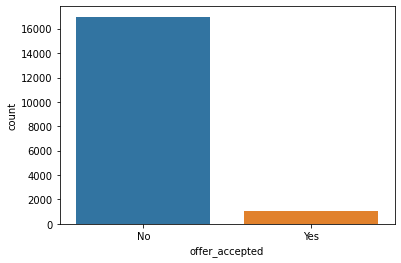

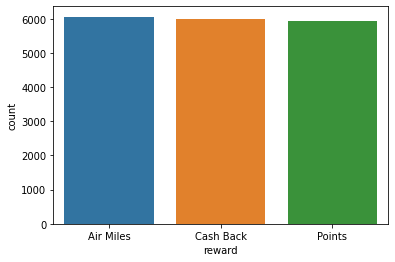

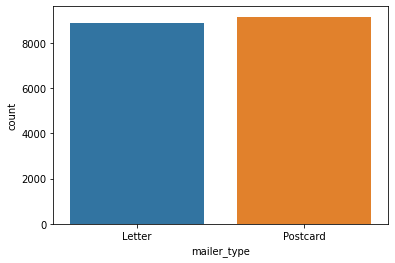

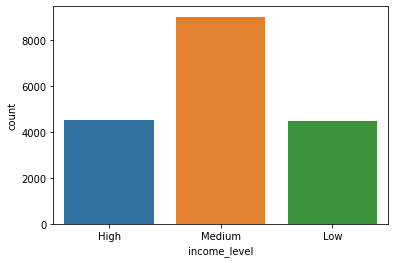

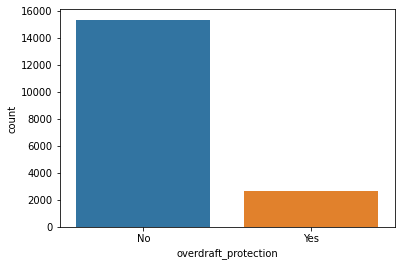

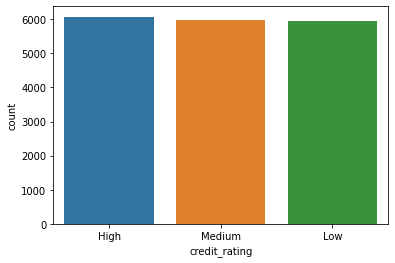

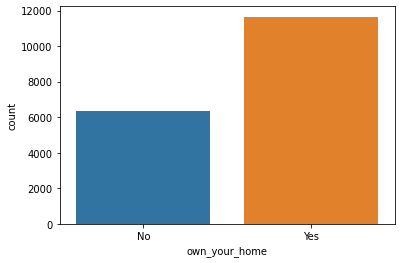

In [9]:
for col in df_cat:
    sns.countplot(df_cat[col])
    plt.show()

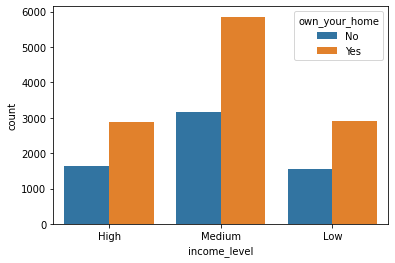

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="income_level", hue="own_your_home")
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="state", hue="location_code")
plt.show()

### 2.2  Then numerical variables

**Dealing with NAN values**

In [9]:
df.isna().sum()

offer_accepted           0
reward                   0
mailer_type              0
income_level             0
bank_accounts_open       0
overdraft_protection     0
credit_rating            0
credit_cards_held        0
homes_owned              0
household_size           0
own_your_home            0
average_balance         24
q1_balance              24
q2_balance              24
q3_balance              24
q4_balance              24
dtype: int64

In [10]:
# checking the rows that are null 
df[df['q1_balance'].isna()==True] 

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
324,No,Points,Postcard,Medium,1,No,High,1,1,4,No,NaN,NaN,NaN,NaN,NaN
3071,Yes,Air Miles,Postcard,Low,3,No,Medium,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3109,No,Air Miles,Letter,Low,1,No,High,3,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3790,No,Air Miles,Letter,Medium,2,No,High,3,1,3,No,NaN,NaN,NaN,NaN,NaN
5084,No,Points,Letter,Medium,1,No,High,1,1,3,Yes,NaN,NaN,NaN,NaN,NaN
5678,No,Air Miles,Postcard,Low,1,No,Low,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
5690,No,Air Miles,Postcard,Medium,1,No,Medium,3,1,5,No,NaN,NaN,NaN,NaN,NaN
6933,No,Air Miles,Postcard,Medium,1,No,Medium,2,2,4,Yes,NaN,NaN,NaN,NaN,NaN
7788,No,Air Miles,Letter,Low,2,No,Low,1,1,4,Yes,NaN,NaN,NaN,NaN,NaN


In [81]:
# since there are only 24 rows with NAN values in the whole dataframe i.e 0,13% of the data, I will drop them.

df = df.dropna()
df = df.reset_index(drop=True)


**Exploring data**

In [101]:
df.describe()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600,810.185803
std,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


**Create a function to plot graphs of the continuous and discrete variables**

In [13]:
def numerical_plotting(df):
    continuous = df.select_dtypes('float64')
    discrete = df.select_dtypes('int64')
    
    for col in continuous:
        sns.distplot(continuous[col])
        plt.show()
        
    for col in discrete:
        sns.countplot(discrete[col])
        plt.show()

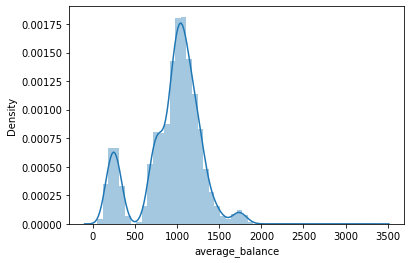

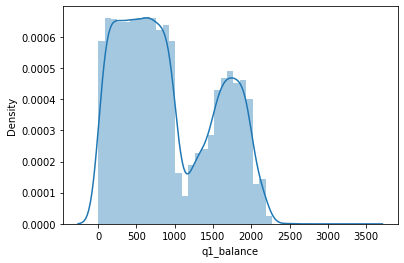

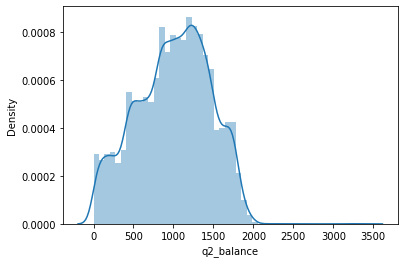

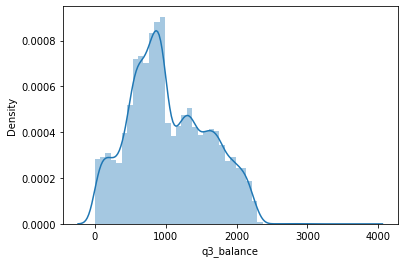

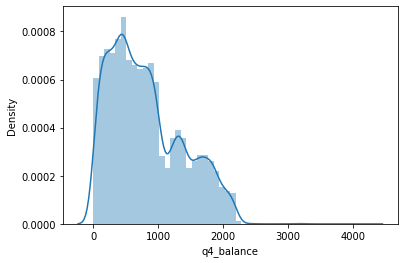

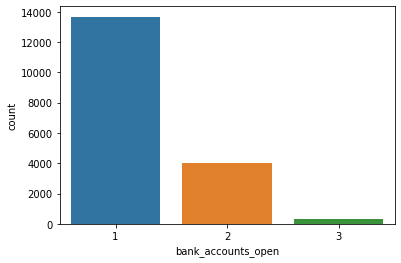

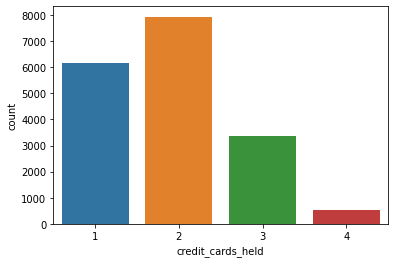

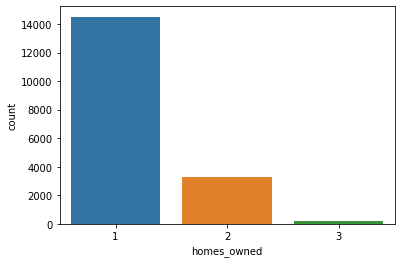

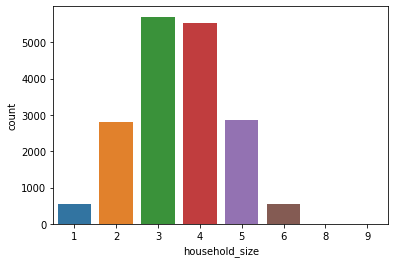

In [14]:
numerical_plotting(df)

Correlation analysis

Covariance visualization :
we are only working on continuous variables since the discrete variables are featured as categorical variables.

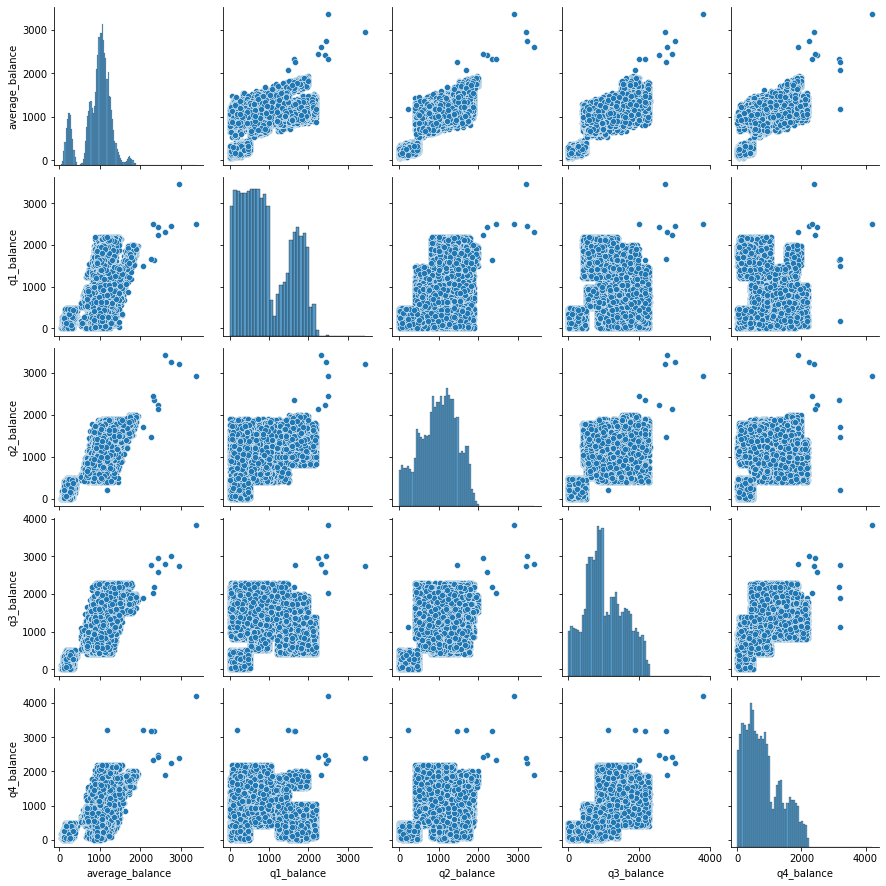

In [16]:
continuous = df.select_dtypes('float64')
sns.pairplot(continuous)

# save the figure
# plt.savefig('covariance_account_balance.png', dpi=100, bbox_inches='tight')
plt.show()

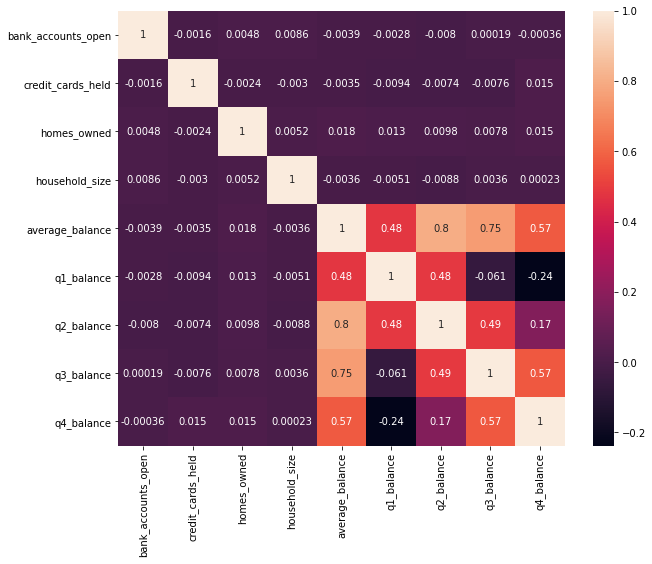

In [18]:
corr_matrix=df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [74]:
# We decide to drop the average_balance variable 
#because it has high correlation score with 2 other variables (q2_balance and q3_balance)
df = df.drop(['average_balance'], axis=1)

**Checking on outliers**

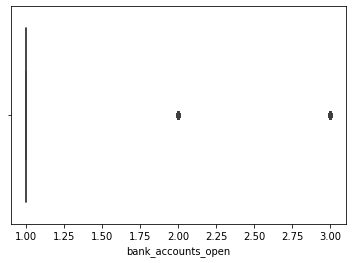

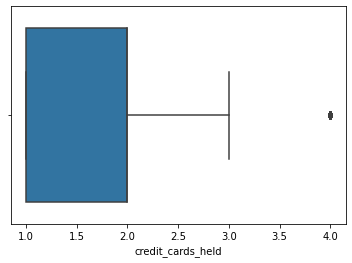

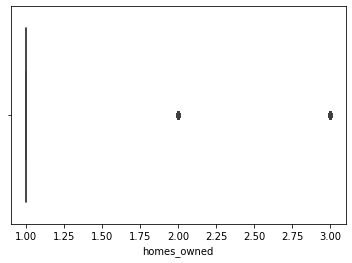

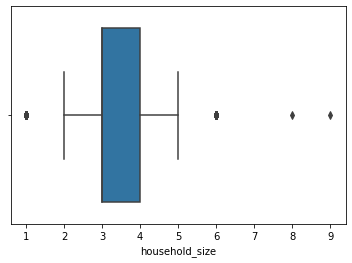

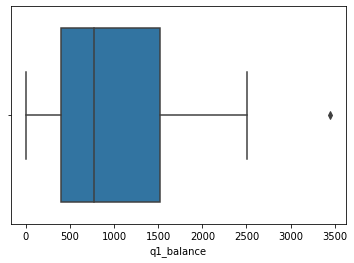

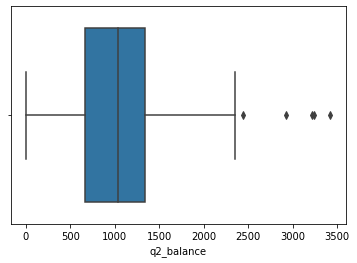

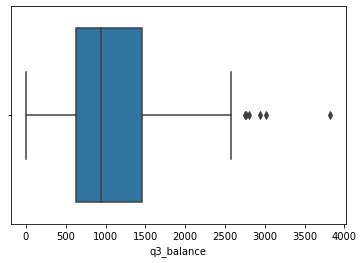

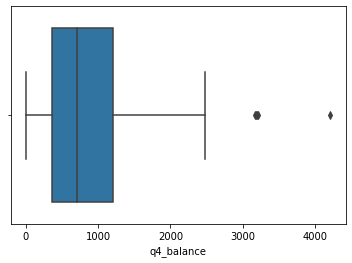

In [16]:
# vizualizing outliers
df_num = df._get_numeric_data() 
for col in df_num:
    sns.boxplot(df_num[col])
    plt.show()

**The outliers should not have relevant impact on our analysis. we will not remove them.**

## 2.3 - Exploration of the target variable : "accepted_offer"

We have already seen that the target variable is higly imbalanced. We will need to deal with this issue.
First, we will explore colinearity between variables

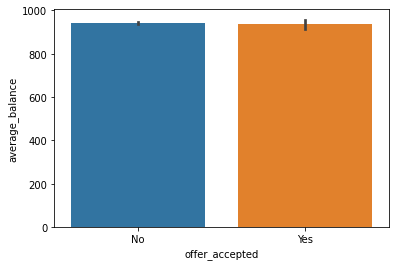

In [20]:
# average_balance vs offer_accepted

plt.figure(figsize=(6,4))
sns.barplot(data=df, y="average_balance", x="offer_accepted")
plt.show()

In [21]:
# Did the customers with the highest average balance accept the offer?

df.nlargest(20,columns="average_balance")[["average_balance","offer_accepted","mailer_type","income_level","own_your_home", "credit_rating","bank_accounts_open","credit_cards_held"]]

,average_balance,offer_accepted,mailer_type,income_level,own_your_home,credit_rating,bank_accounts_open,credit_cards_held
2295,3366.25,No,Letter,High,No,Medium,1,2
12619,2948.50,No,Letter,High,No,High,1,3
8875,2738.50,No,Letter,Medium,Yes,Medium,1,2
10563,2609.50,No,Letter,Medium,Yes,High,3,1
13984,2437.50,No,Letter,Medium,Yes,Medium,1,1
10462,2430.00,No,Letter,Medium,Yes,High,1,1
2654,2336.75,No,Letter,Medium,No,Low,1,2
15238,2320.50,No,Letter,Medium,No,High,1,2
15587,2271.50,No,Postcard,High,Yes,Low,1,1
8765,2073.25,No,Postcard,Medium,No,High,1,1


In [22]:
# Same question but with the customers with the lowest average balance?

df.nsmallest(20,columns="average_balance")[["average_balance","offer_accepted","mailer_type","income_level","own_your_home", "credit_rating","bank_accounts_open","credit_cards_held"]]

,average_balance,offer_accepted,mailer_type,income_level,own_your_home,credit_rating,bank_accounts_open,credit_cards_held
5703,48.25,No,Postcard,Medium,Yes,Medium,2,1
2791,56.00,No,Letter,Medium,Yes,Low,2,3
13301,62.00,No,Letter,High,Yes,Medium,1,3
11262,63.50,No,Postcard,Medium,No,High,1,1
5143,71.25,No,Postcard,Medium,No,High,1,3
12892,74.50,No,Letter,High,Yes,Medium,1,1
13142,75.25,No,Postcard,Medium,Yes,Low,1,2
4220,75.75,Yes,Postcard,High,Yes,Low,1,3
6699,76.25,No,Letter,Low,Yes,Low,1,1
4335,79.00,No,Postcard,Medium,No,Low,2,2


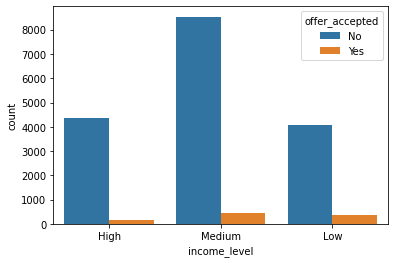

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="income_level", hue="offer_accepted")
plt.show()

Checking correlation between variables

The p_value is used for hypothesis testing and it can be used to measure dependency between two variables.

A low p_value means that there is significant relationship between two variables.

A reasonable threshold for p_value is 0.05, and it's related to a confidence interval of 95%. 

For now: a p_value below 0.05 means that there is a considerable correlation between two variables, and it is likely that one of them can be dropped without decreasing the metrics of the model.

**correlation between 'offer_accepted' and 'income_level'**

In [94]:
# contingency table
data_crosstab = pd.crosstab(df_cat['offer_accepted'], df_cat['income_level'], margins = False)
data_crosstab

income_level,High,Low,Medium,All
offer_accepted,,,,
No,4361,4073,8543,16977
Yes,165,388,470,1023
All,4526,4461,9013,18000


In [66]:
chi2_contingency(data_crosstab, correction=False)

(114.36759816901265,
 1.463496214215802e-25,
 2,
 array([[4268.77233333, 4207.4665    , 8500.76116667],
        [ 257.22766667,  253.5335    ,  512.23883333]]))

In [87]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab)
p_value

1.463496214215802e-25

**Correlation between 'credit_rating' and 'own_your_home'**

In [93]:
data_crosstab1 = pd.crosstab(df_cat['credit_rating'], df_cat['own_your_home'], margins = False)
data_crosstab1

own_your_home,No,Yes
credit_rating,,
High,2142,3929
Low,2126,3831
Medium,2077,3895


In [95]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab1)
p_value

0.5808393854017466

## 3. Preprocessing and Modeling

We will use different models to compare them and find the one which fits better our data. We will apply two algorithms : Logistic Regression and KNN Classifier.

In [138]:
# create a copy
df1 = df.copy()
df2 = df.copy()

### 3.1 - Preprocessing - using boxcox and SMOTE
1. Boxcox transformation on continuous variables only
2. Encoding - get dummies
3. Dealing with imbalanced - SMOTE
4. Modeling

#### Boxcox transformation

We will apply it on the following columns : 'average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance' to help our features to have a more normal distribution.

In [84]:
#Boxcox transformation

def boxcox_transform(df):
    numeric_cols = df.select_dtypes('float64').columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

df, _ci = boxcox_transform(df)
df

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,8703.958501,73.836626,639.885262,173.975094,50.525011
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,563.218895,10.157140,85.875613,27.328789,30.922576
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,1299.266926,34.277501,269.331501,42.538730,25.166504
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,9287.622984,71.795308,1237.254765,176.596534,33.055723
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,9206.914353,83.588729,967.349381,161.378408,30.880781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,668.250437,20.364395,53.691759,25.535159,32.228934
17972,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,5763.396657,56.640150,683.333055,156.926025,37.265522
17973,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,7981.026326,54.691416,563.606453,182.108919,61.203573
17974,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,7354.790374,45.051227,712.896118,147.842192,63.524960


In [85]:
#drop the target
X = df.drop('offer_accepted', axis=1)
y = df['offer_accepted']

#### Encoding

In [86]:
X= pd.get_dummies(X)
X

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,reward_Air Miles,...,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
0,1,2,1,4,8703.958501,73.836626,639.885262,173.975094,50.525011,1,...,1,0,0,1,0,1,0,0,1,0
1,1,2,2,5,563.218895,10.157140,85.875613,27.328789,30.922576,1,...,0,0,1,1,0,0,0,1,0,1
2,2,2,1,2,1299.266926,34.277501,269.331501,42.538730,25.166504,1,...,1,0,0,1,0,0,0,1,0,1
3,2,1,1,4,9287.622984,71.795308,1237.254765,176.596534,33.055723,1,...,0,0,1,1,0,1,0,0,1,0
4,1,2,1,6,9206.914353,83.588729,967.349381,161.378408,30.880781,1,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,1,1,1,5,668.250437,20.364395,53.691759,25.535159,32.228934,0,...,1,0,0,1,0,0,1,0,0,1
17972,1,3,1,3,5763.396657,56.640150,683.333055,156.926025,37.265522,0,...,1,0,0,1,0,0,1,0,0,1
17973,1,2,1,4,7981.026326,54.691416,563.606453,182.108919,61.203573,0,...,1,0,0,1,0,0,1,0,1,0
17974,1,4,2,2,7354.790374,45.051227,712.896118,147.842192,63.524960,0,...,0,0,1,1,0,0,0,1,0,1


#### Dealing with imbalanced data

In [87]:
# SMOTE
# Uses knn to create rows with similar features from the minority classes.

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     16955
Yes    16955
Name: offer_accepted, dtype: int64

#### Modeling

**Logistic Regression**

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [89]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [90]:
#evaluate the model
classification.score(X_test, y_test)

0.9628428192273666

In [92]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[3391,    1],
       [ 251, 3139]], dtype=int64)

<AxesSubplot:>

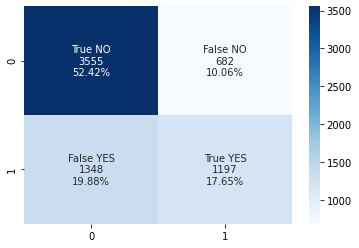

In [238]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

**KNN-Classifier**

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_f, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_f, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_f, y_test)))

In [ ]:
y_pred = knn.predict(X_test_f)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 3.2 - Preprocessing using BoxCox and Parameter Tuning

1. Boxcox transformation on continuous variables only
2. Parameter Tuning: class_weight
3. Encoding - get dummies
4. Modeling

#### Boxcox transformation

In [96]:
#Boxcox transformation

def boxcox_transform(df):
    numeric_cols = df.select_dtypes('float64').columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

df1, _ci = boxcox_transform(df1)
df1

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,8703.958501,73.836626,639.885262,173.975094,50.525011
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,563.218895,10.157140,85.875613,27.328789,30.922576
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,1299.266926,34.277501,269.331501,42.538730,25.166504
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,9287.622984,71.795308,1237.254765,176.596534,33.055723
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,9206.914353,83.588729,967.349381,161.378408,30.880781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,668.250437,20.364395,53.691759,25.535159,32.228934
17972,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,5763.396657,56.640150,683.333055,156.926025,37.265522
17973,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,7981.026326,54.691416,563.606453,182.108919,61.203573
17974,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,7354.790374,45.051227,712.896118,147.842192,63.524960


#### Parameter Tuning - Encoding

In [97]:
df1.offer_accepted.value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

In [239]:
# Drop Target column and Get Dummies First

X1 = pd.get_dummies(df1.drop('offer_accepted', axis=1))
y1 = df1['offer_accepted']

total = sum(df1['offer_accepted'].value_counts())

weights = {'No': total/(2*df1['offer_accepted'].value_counts()['No']),
           'Yes': total/(2*df1['offer_accepted'].value_counts()['Yes'])}

In [105]:
weights

{'No': 0.5301091123562371, 'Yes': 8.80313418217434}

#### Modeling

**Logistic Regression**

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [107]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [108]:
classification.score(X_test, y_test)

0.9468854282536151

In [109]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[3405,    0],
       [ 191,    0]], dtype=int64)

<AxesSubplot:>

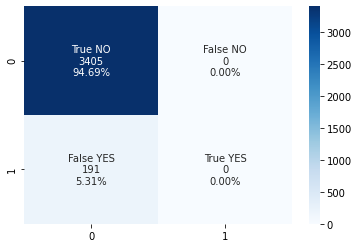

In [34]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

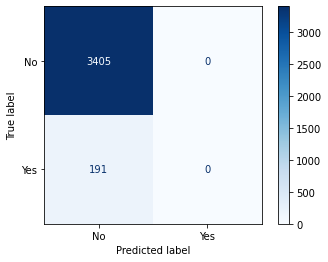

In [62]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

**KNN Classifier**

In [64]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 0.95


In [ ]:
y_pred = knn.predict(X_test_f)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 3.3 - Preprocessing using Upsampling and normalization

1. Numerical columns in a list
2. Dealing with imbalanced - UpSampling
3. Encoding - get dummies
4. train-test split
5. Normalization of the numerical columns
6. Modeling

In [140]:
numerical = df2.select_dtypes(np.number)

numerical.columns

Index(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

In [37]:
num_col = ['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance','q1_balance', 'q2_balance', 'q3_balance',
       'q4_balance']

#### Upsampling

In [143]:
df2['offer_accepted'].value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

In [208]:
# Manually
# getting sample with the 60% as the minority class
Yes = df[df['offer_accepted'] == 'Yes'].sample(10173, replace=True)
No = df[df['offer_accepted'] == 'No'].sample(16955, replace=True)

upsampled = pd.concat([Yes,No]).sample(frac=1) # .sample(frac=1) here is just to shuffle the dataframe
upsampled

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
9031,Yes,Points,Postcard,Low,1,Yes,Low,2,1,5,Yes,8766.136137,12.757285,1301.684548,214.926681,56.515148
9283,No,Cash Back,Postcard,Medium,1,No,Medium,3,2,3,Yes,4122.124390,50.303816,564.998431,111.989312,36.612301
6442,No,Points,Letter,High,1,Yes,Medium,1,1,3,Yes,4485.820383,45.596824,594.185165,107.797989,45.756464
1582,No,Points,Postcard,Medium,1,No,High,1,2,4,Yes,9365.974032,56.553055,957.900787,151.948966,64.788580
10650,No,Cash Back,Postcard,Low,2,No,High,3,2,4,Yes,1249.648736,24.791565,179.022978,46.605119,35.446236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,Yes,Air Miles,Postcard,Low,1,Yes,High,2,1,3,Yes,6430.447609,31.309006,639.194272,191.025695,56.343415
13471,Yes,Points,Letter,Low,2,No,Low,3,1,5,Yes,6999.301853,36.470377,960.600931,160.469721,55.190523
12640,No,Points,Letter,Medium,1,No,High,3,1,4,Yes,11034.420057,55.939521,603.895550,235.188009,71.539374
473,No,Air Miles,Letter,Low,1,No,Medium,2,1,3,Yes,7830.556729,33.987402,878.042993,242.956690,48.563418


#### Encoding

In [209]:
X = upsampled.drop('offer_accepted', axis=1)
y = upsampled['offer_accepted']

In [210]:
X = pd.get_dummies(X)
X

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,reward_Air Miles,...,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
9031,1,2,1,5,8766.136137,12.757285,1301.684548,214.926681,56.515148,0,...,0,1,0,0,1,0,1,0,0,1
9283,1,3,2,3,4122.124390,50.303816,564.998431,111.989312,36.612301,0,...,0,0,1,1,0,0,0,1,0,1
6442,1,1,1,3,4485.820383,45.596824,594.185165,107.797989,45.756464,0,...,1,0,0,0,1,0,0,1,0,1
1582,1,1,2,4,9365.974032,56.553055,957.900787,151.948966,64.788580,0,...,0,0,1,1,0,1,0,0,0,1
10650,2,3,2,4,1249.648736,24.791565,179.022978,46.605119,35.446236,0,...,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1,2,1,3,6430.447609,31.309006,639.194272,191.025695,56.343415,1,...,0,1,0,0,1,1,0,0,0,1
13471,2,3,1,5,6999.301853,36.470377,960.600931,160.469721,55.190523,0,...,0,1,0,1,0,0,1,0,0,1
12640,1,3,1,4,11034.420057,55.939521,603.895550,235.188009,71.539374,0,...,0,0,1,1,0,1,0,0,0,1
473,1,2,1,3,7830.556729,33.987402,878.042993,242.956690,48.563418,1,...,0,1,0,1,0,0,0,1,0,1


#### Normalizing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [212]:
X_train_n = X_train.filter(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance','q1_balance', 'q2_balance', 'q3_balance',
       'q4_balance'], axis = 1)

X_test_n = X_test.filter(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance','q1_balance', 'q2_balance', 'q3_balance',
       'q4_balance'], axis = 1)

In [213]:
transformer = Normalizer()
transformer.fit(X_train_n)

# saving in a pickle
with open('std_transformer.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('std_transformer.pickle', 'rb') as file:
    loaded_normalizer = pickle.load(file)

X_train_ = loaded_normalizer.transform(X_train_n)
X_test_ = loaded_normalizer.transform(X_test_n)

In [214]:
num_train = pd.DataFrame(X_train_, columns = num_col)
num_test = pd.DataFrame(X_test_, columns = num_col)

In [215]:
X_train.columns

Index(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance', 'reward_Air Miles', 'reward_Cash Back',
       'reward_Points', 'mailer_type_Letter', 'mailer_type_Postcard',
       'income_level_High', 'income_level_Low', 'income_level_Medium',
       'overdraft_protection_No', 'overdraft_protection_Yes',
       'credit_rating_High', 'credit_rating_Low', 'credit_rating_Medium',
       'own_your_home_No', 'own_your_home_Yes'],
      dtype='object')

In [216]:
X_train_c = X_train.filter(['reward_Air Miles', 'reward_Cash Back', 'reward_Points',
       'mailer_type_Letter', 'mailer_type_Postcard', 'income_level_High',
       'income_level_Low', 'income_level_Medium', 'overdraft_protection_No',
       'overdraft_protection_Yes', 'credit_rating_High', 'credit_rating_Low',
       'credit_rating_Medium', 'own_your_home_No', 'own_your_home_Yes'], axis = 1)

In [217]:
X_train_f= pd.concat(
    [
        num_train.reset_index(drop=True),
        X_train_c.reset_index(drop=True)
    ], 
    axis=1, ignore_index=True)

X_train_f.info() #checking NAN values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20346 entries, 0 to 20345
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20346 non-null  float64
 1   1       20346 non-null  float64
 2   2       20346 non-null  float64
 3   3       20346 non-null  float64
 4   4       20346 non-null  float64
 5   5       20346 non-null  float64
 6   6       20346 non-null  float64
 7   7       20346 non-null  float64
 8   8       20346 non-null  float64
 9   9       20346 non-null  uint8  
 10  10      20346 non-null  uint8  
 11  11      20346 non-null  uint8  
 12  12      20346 non-null  uint8  
 13  13      20346 non-null  uint8  
 14  14      20346 non-null  uint8  
 15  15      20346 non-null  uint8  
 16  16      20346 non-null  uint8  
 17  17      20346 non-null  uint8  
 18  18      20346 non-null  uint8  
 19  19      20346 non-null  uint8  
 20  20      20346 non-null  uint8  
 21  21      20346 non-null  uint8  
 22

In [218]:
X_test_c = X_test.filter(['reward_Air Miles', 'reward_Cash Back', 'reward_Points',
       'mailer_type_Letter', 'mailer_type_Postcard', 'income_level_High',
       'income_level_Low', 'income_level_Medium', 'overdraft_protection_No',
       'overdraft_protection_Yes', 'credit_rating_High', 'credit_rating_Low',
       'credit_rating_Medium', 'own_your_home_No', 'own_your_home_Yes'], axis = 1)

In [219]:
X_test_f= pd.concat(
    [
        num_test.reset_index(drop=True),
        X_test_c.reset_index(drop=True)
    ], 
    axis=1, ignore_index=True)

X_test_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6782 entries, 0 to 6781
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6782 non-null   float64
 1   1       6782 non-null   float64
 2   2       6782 non-null   float64
 3   3       6782 non-null   float64
 4   4       6782 non-null   float64
 5   5       6782 non-null   float64
 6   6       6782 non-null   float64
 7   7       6782 non-null   float64
 8   8       6782 non-null   float64
 9   9       6782 non-null   uint8  
 10  10      6782 non-null   uint8  
 11  11      6782 non-null   uint8  
 12  12      6782 non-null   uint8  
 13  13      6782 non-null   uint8  
 14  14      6782 non-null   uint8  
 15  15      6782 non-null   uint8  
 16  16      6782 non-null   uint8  
 17  17      6782 non-null   uint8  
 18  18      6782 non-null   uint8  
 19  19      6782 non-null   uint8  
 20  20      6782 non-null   uint8  
 21  21      6782 non-null   uint8  
 22  

#### Modeling

**Logistic Regression**

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train_f, y_train)

In [221]:
classification.score(X_test_f, y_test)

0.7006782659982306

In [222]:
predictions = classification.predict(X_test_f)
confusion_matrix(y_test, predictions)

array([[3555,  682],
       [1348, 1197]], dtype=int64)

<AxesSubplot:>

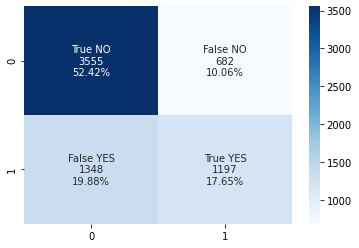

In [223]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

**KNN Classifier**

In [228]:
knn = KNeighborsClassifier()
knn.fit(X_train_f, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_f, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_f, y_test)))

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 0.90


In [232]:
y_pred = knn.predict(X_test_f)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8963432615747567
              precision    recall  f1-score   support

          No       0.99      0.84      0.91      4237
         Yes       0.79      0.98      0.88      2545

    accuracy                           0.90      6782
   macro avg       0.89      0.91      0.89      6782
weighted avg       0.91      0.90      0.90      6782

[[3579  658]
 [  45 2500]]


<AxesSubplot:>

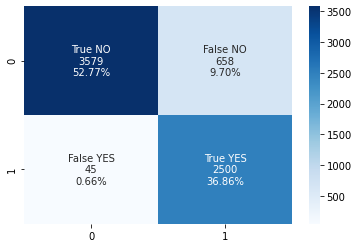

In [234]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')